# Brincando com Visão Computacional
## Misturando Faces

Importando as bibliotecas necessárias

In [24]:
from matplotlib import pyplot as plt
import cv2
import dlib
import numpy
from time import sleep
import sys

Criando uma função para receber duas imagens e exibir em tela

In [25]:
def post_images(images):
    plt.figure(figsize=(20,20))

    length = len(images)

    for count in range(length):
        plt.subplot(1, length, count + 1)
        plt.imshow(cv2.cvtColor(images[count]['content'], cv2.COLOR_BGR2RGB))
        plt.title(images[count]['title'])
        plt.axis('off')

In [26]:
image_fausto = cv2.imread('images/fausto.png')
image_silvio = cv2.imread('images/silvio.jpg')

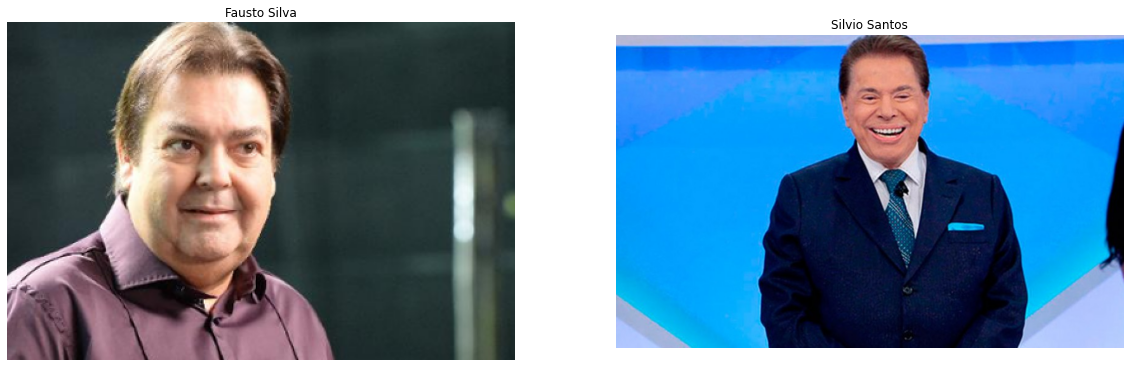

In [27]:
post_images([{ 'content': image_fausto, 'title': 'Fausto Silva' }, { 'content': image_silvio, 'title': 'Silvio Santos' }])

In [28]:
SCALE_FACTOR = 1 # fator de escala
FEATHER_AMOUNT = 11 # Gaussian Kernel Size
COLOUR_CORRECT_BLUR_FRAC = 0.6 # quantidade de desfoque a ser usada durante a correção de cores, como uma fração da distância pupilar

In [29]:
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

In [30]:
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS + RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)
OVERLAY_POINTS = [LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS, NOSE_POINTS + MOUTH_POINTS]

In [31]:
detector = dlib.get_frontal_face_detector()
classifier_68_path = "models/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(classifier_68_path)

Obtendo as coordenadas dos pontos de referências faciais

In [32]:
def get_landmarks(image):
    rects = detector(image, 1)
    
    if len(rects) > 1:
        return image
    if len(rects) == 0:
        return image

    return numpy.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

Inserindo os pontos encontrados na imagem

In [33]:
def annotate_landmarks(image, landmarks):
    image = image.copy()

    for idx, point in enumerate(landmarks):
        position = (point[0, 0], point[0, 1])
        cv2.putText(image, str(idx), position, fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=0.4, color=(0, 0, 255))
        cv2.circle(image, position, 3, color=(0, 255, 255))
    
    return image

In [34]:
def draw_convex_hull(image, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(image, points, color=color)

In [35]:
def get_face_mask(image, landmarks):
    image = numpy.zeros(image.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(image, landmarks[group], color=1)

    image = numpy.array([image, image, image]).transpose((1, 2, 0))

    image = (cv2.GaussianBlur(image, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    image = cv2.GaussianBlur(image, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return image

Aproximação de matrizes com o [Orthogonal Procrustes Problem](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem)

In [36]:
def transformation_from_points(points1, points2):
    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)

    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R, c2.T - (s2 / s1) * R * c1.T)), numpy.matrix([0., 0., 1.])])

In [37]:
def read_image_and_landmarks(image):
    image = cv2.resize(image, None, fx=1, fy=1, interpolation = cv2.INTER_LINEAR)
    image = cv2.resize(image, (image.shape[1] * SCALE_FACTOR, image.shape[0] * SCALE_FACTOR))
    image_scale = get_landmarks(image)
    return image, image_scale

In [38]:
def warp_im(im, M, dshape):
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im, M[:2], (dshape[1], dshape[0]), dst=output_im, borderMode=cv2.BORDER_TRANSPARENT, flags=cv2.WARP_INVERSE_MAP)
    return output_im

In [39]:
def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) - numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)

    if blur_amount % 2 == 0:
        blur_amount += 1
        
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) / im2_blur.astype(numpy.float64))

In [40]:
def swappy(image1, image2):
    image1, landmarks1 = read_image_and_landmarks(image1)
    image2, landmarks2 = read_image_and_landmarks(image2)

    M = transformation_from_points(landmarks1[ALIGN_POINTS], landmarks2[ALIGN_POINTS])
    
    mask = get_face_mask(image2, landmarks2)
    warped_mask = warp_im(mask, M, image1.shape)
    combined_mask = numpy.max([get_face_mask(image1, landmarks1), warped_mask], axis=0)

    warped_image2 = warp_im(image2, M, image1.shape)
    warped_corrected_image2 = correct_colours(image1, warped_image2, landmarks1)

    output_image = image1 * (1.0 - combined_mask) + warped_corrected_image2 * combined_mask
    cv2.imwrite('output.jpg', output_image)
    image = cv2.imread('output.jpg')
    return image

In [41]:
image_fausto_silvio = swappy(image_fausto, image_silvio)
image_silvio_fausto = swappy(image_silvio, image_fausto)

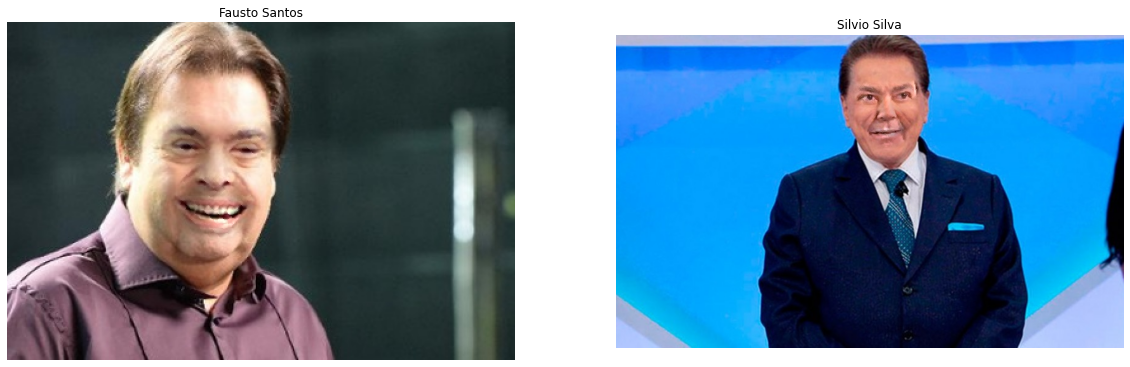

In [42]:
post_images([{ 'content': image_fausto_silvio, 'title': 'Fausto Santos' }, { 'content': image_silvio_fausto, 'title': 'Silvio Silva' }])

In [43]:
image_lennon = cv2.imread('images/lennon.jpeg')
image_diana = cv2.imread('images/diana.jpg')

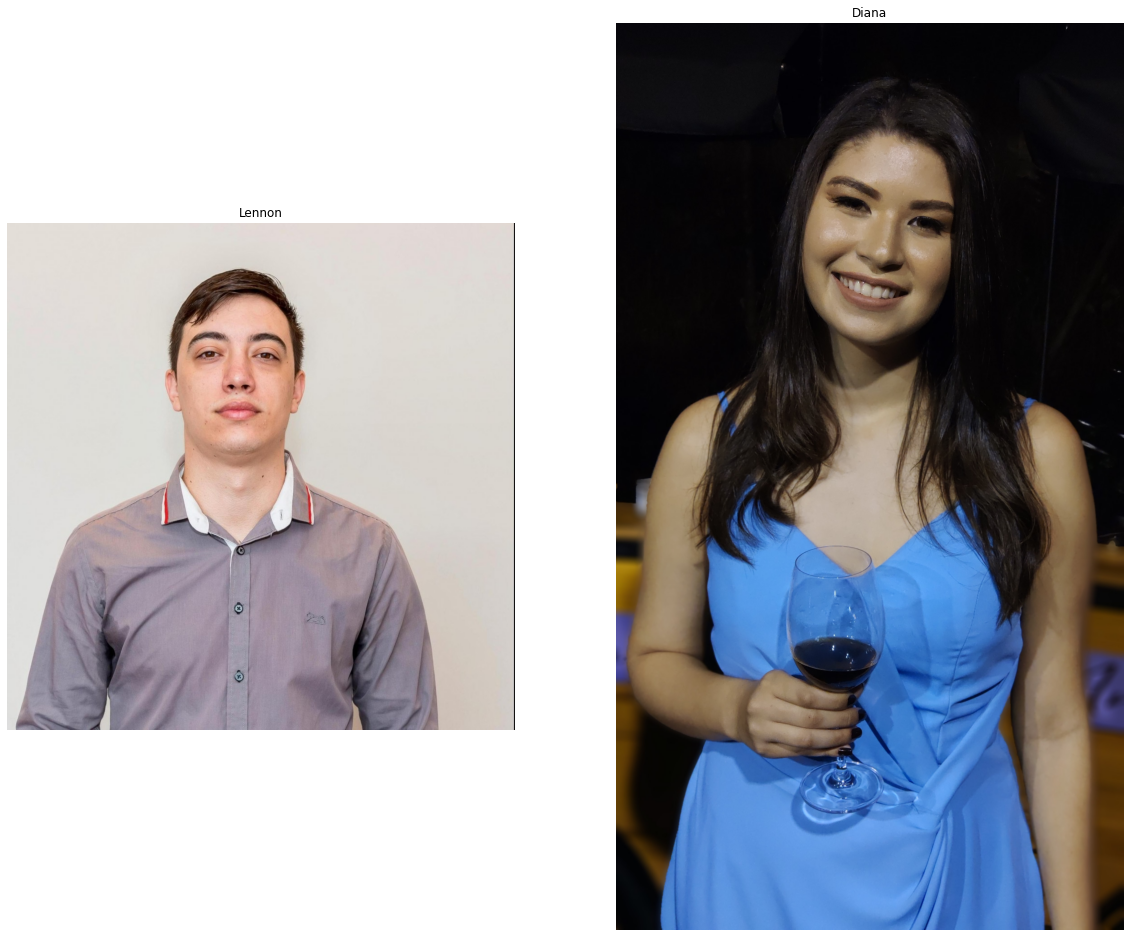

In [44]:
post_images([{ 'content': image_lennon, 'title': 'Lennon' }, { 'content': image_diana, 'title': 'Diana' }])

In [45]:
image_lennon_diana = swappy(image_lennon, image_diana)
image_diana_lennon = swappy(image_diana, image_lennon)

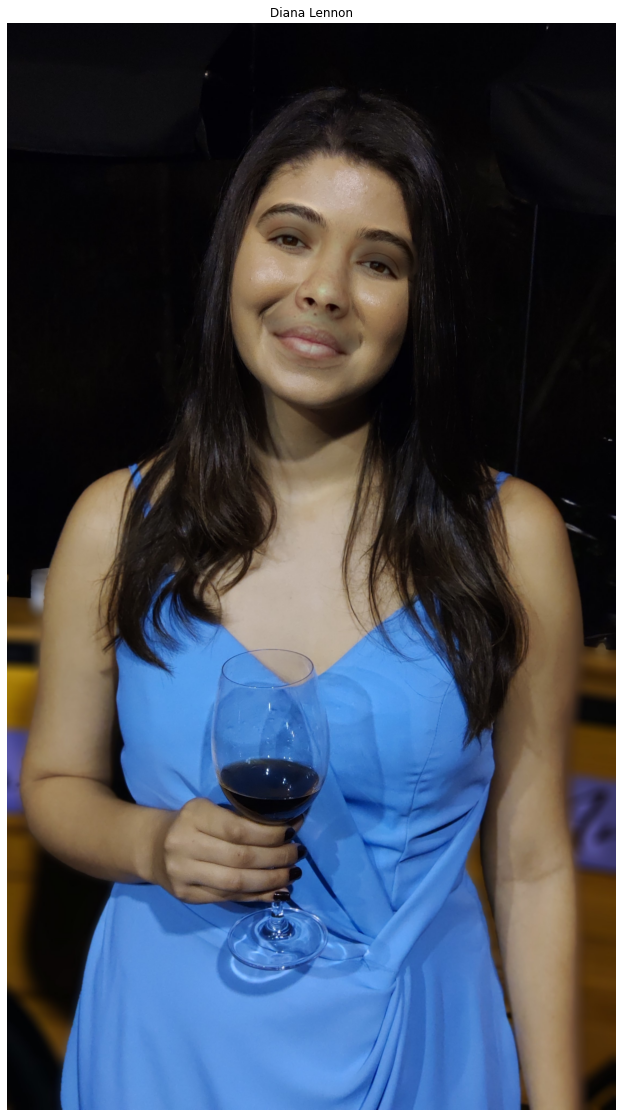

In [46]:
post_images([{ 'content': image_diana_lennon, 'title': 'Diana Lennon' }])